<a href="https://colab.research.google.com/github/yangste333/education_inequality/blob/main/DATA_3320_Education_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

##### $\rightarrow$ Provide a brief introduction to the purpose of this notebook.

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Import additional libraries

## Load clean data

##### $\rightarrow$ Load the clean data set from Github. 

In [3]:
train_data = pd.read_csv('https://raw.githubusercontent.com/yangste333/education_inequality/main/data_prep/educ_ineq_training.csv')

##### $\rightarrow$ Review the contents of the data set.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5781 entries, 0 to 5780
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   median_income      5781 non-null   float64
 1   percent_college    5781 non-null   float64
 2   percent_lunch      5781 non-null   float64
 3   percent_married    5781 non-null   float64
 4   rate_unemployment  5781 non-null   float64
 5   school_level       5781 non-null   object 
 6   school_type        5781 non-null   object 
 7   state              5781 non-null   object 
 8   year               5781 non-null   object 
 9   zip_code           5781 non-null   int64  
 10  average_act        5781 non-null   float64
 11  region             5781 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 542.1+ KB


In [5]:
test_data = pd.read_csv('https://raw.githubusercontent.com/yangste333/education_inequality/main/data_prep/educ_ineq_testing.csv')

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1446 entries, 0 to 1445
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   median_income      1446 non-null   float64
 1   percent_college    1446 non-null   float64
 2   percent_lunch      1446 non-null   float64
 3   percent_married    1446 non-null   float64
 4   rate_unemployment  1446 non-null   float64
 5   school_level       1446 non-null   object 
 6   school_type        1446 non-null   object 
 7   state              1446 non-null   object 
 8   year               1446 non-null   object 
 9   zip_code           1446 non-null   int64  
 10  average_act        1446 non-null   float64
 11  region             1446 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 135.7+ KB


## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, you will need to ask specific questions about the data.


Our key questions here are: 
- What numerical factors are most effective in determining ACT scores?
- Does the region a school stay in affect its ACT scores?

## Analysis

To start, here's a pair plot to examine how each of the variables connects with each other. There may be factors that cause one variable to affect another, and using those variables in conjunction with one another to predict another value results in a less useful model.

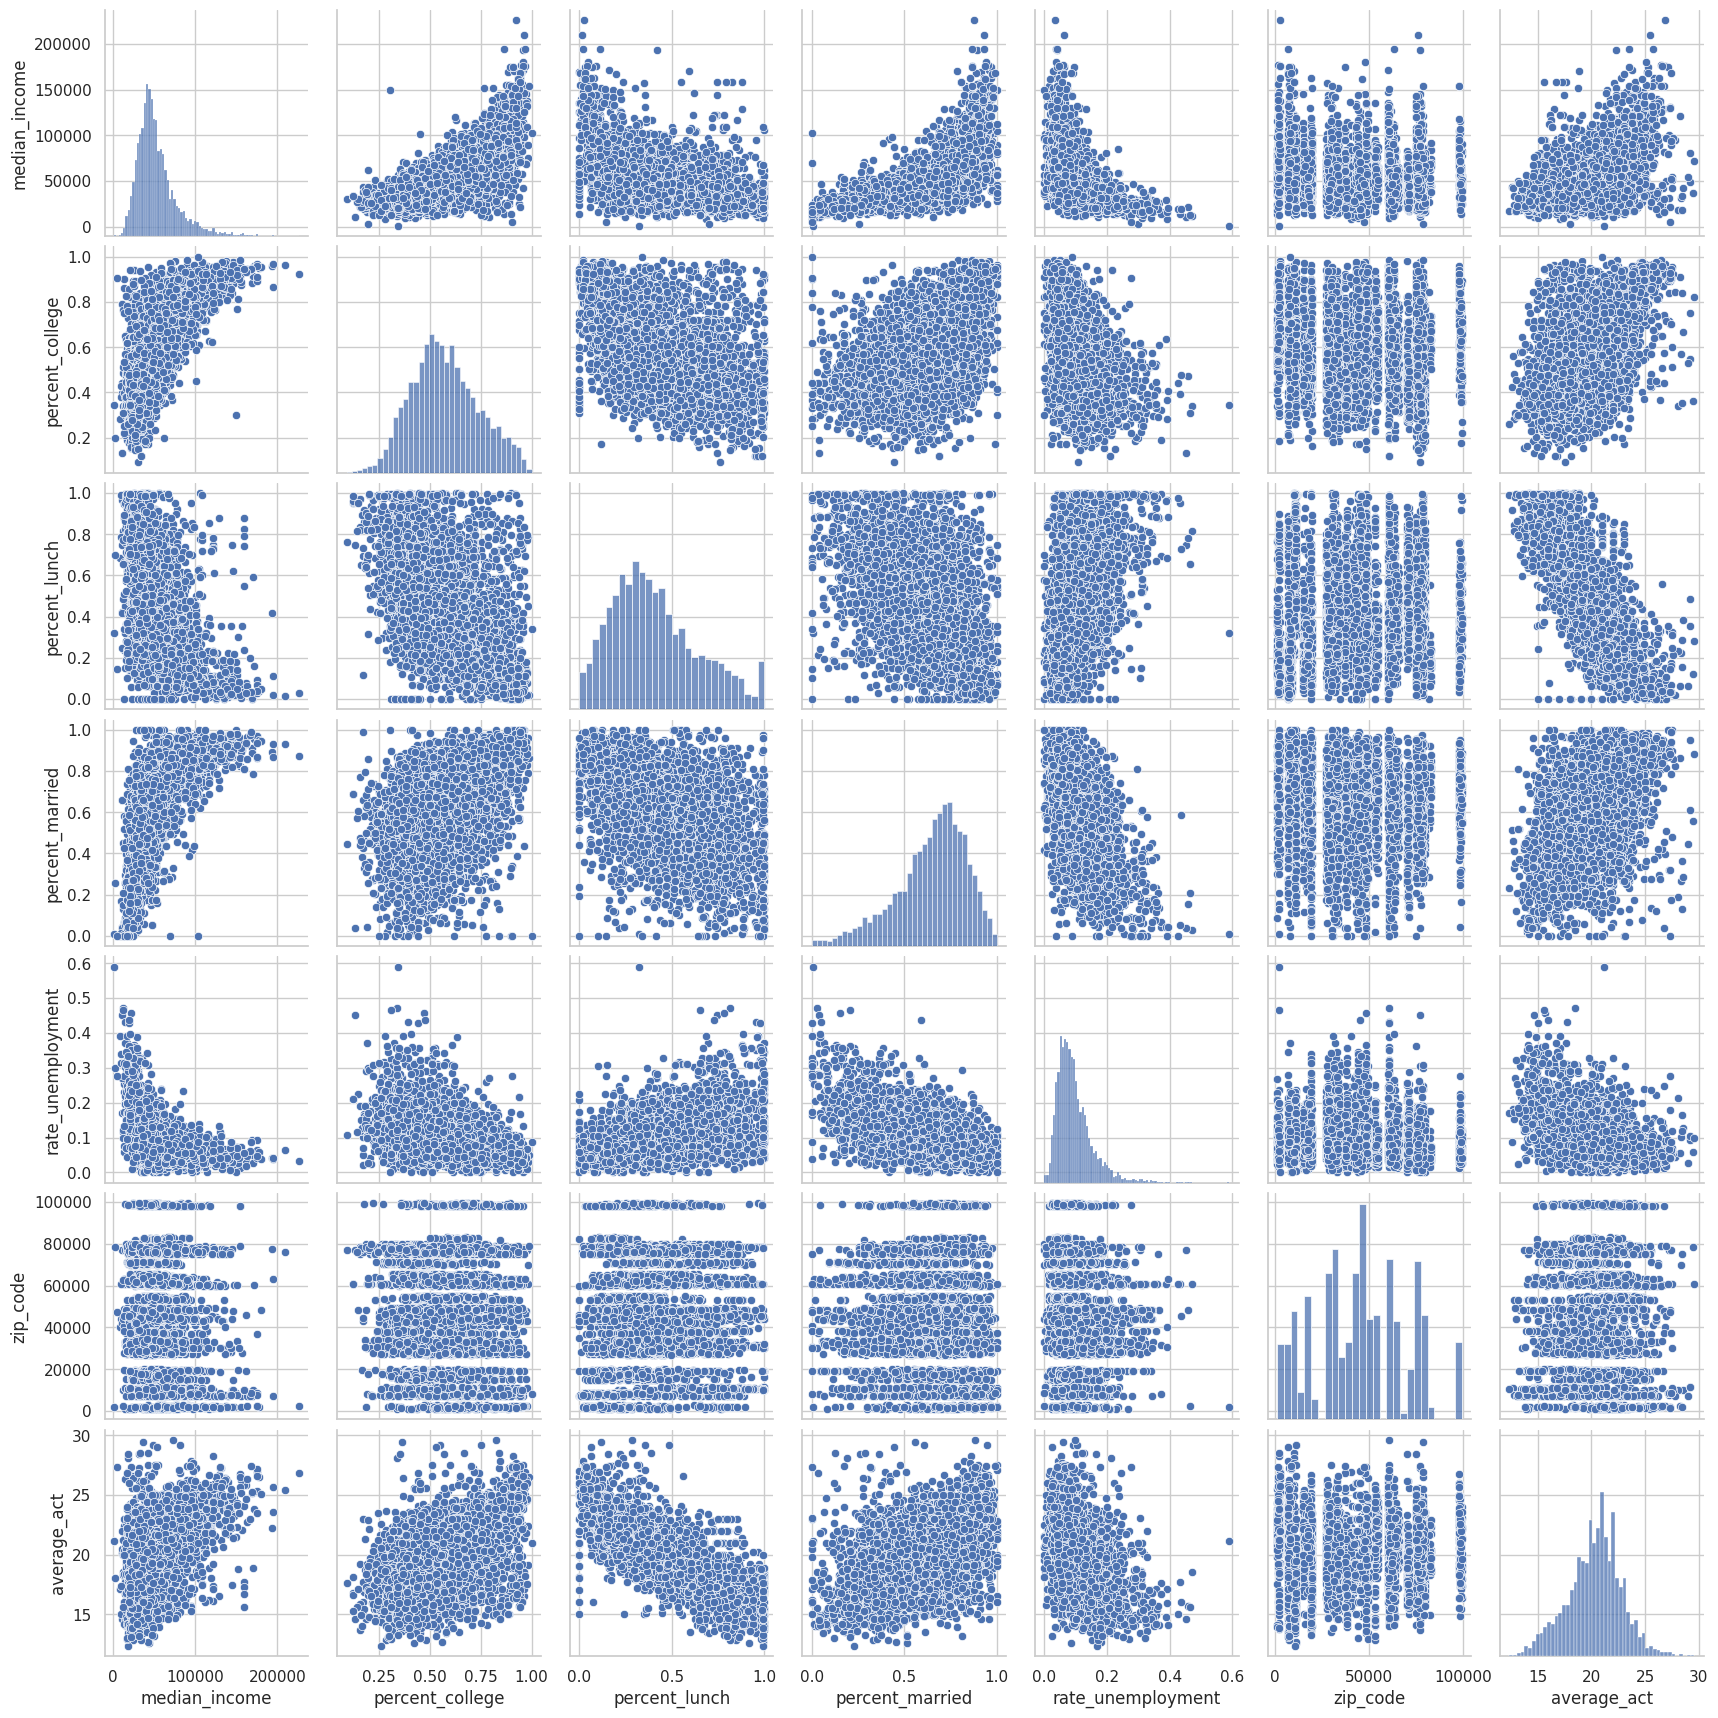

In [7]:
sns.pairplot(train_data)

"median_income" in particular looks like it's heavily connected with a lot of the other factors.

To start, we can create a model based on all of the important numerical factors, as those are easier to work with:

In [8]:
import statsmodels.formula.api as smf

model_all = smf.ols(formula = 'average_act ~ median_income + percent_college + percent_lunch + percent_married + rate_unemployment', data = train_data).fit()
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     1997.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        23:57:37   Log-Likelihood:                -10604.
No. Observations:                5781   AIC:                         2.122e+04
Df Residuals:                    5775   BIC:                         2.126e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.7564      0.15

Alongside that, we can look at each of the factors individually to see what kind of effect they have on the final model:

In [9]:
from itertools import combinations
from math import comb

import statsmodels.api as sm

colnames = train_data.columns.values
numerical_cols = colnames[0:5]

for n in numerical_cols:
  selec = train_data.loc[:, n]
  model_n = sm.OLS(train_data['average_act'], sm.add_constant(selec)).fit()
  print(model_n.summary())

                            OLS Regression Results                            
Dep. Variable:            average_act   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     1540.
Date:                Thu, 04 May 2023   Prob (F-statistic):          9.06e-299
Time:                        23:57:37   Log-Likelihood:                -12824.
No. Observations:                5781   AIC:                         2.565e+04
Df Residuals:                    5779   BIC:                         2.566e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            17.8079      0.070    255.359

As we can see, none of the parameters really has a good R-squared value except for percent_lunch - suggesting that that's the most important parameter to put into the overall model.

Alongside percent_lunch, we want to determine the best subset of factors to use in order to predict the data correctly. To avoid overfitting, we can use measures that punish a larger number of factors, such as adjusted R-squared and AIC/BIC.

From there, we can take the best subsets for each number of factors by R-squared value and compare the best subset for each number of factors through those measures, like so:

In [10]:
best_subs = []

for val in range(1, len(numerical_cols)+1):
  subset = combinations(numerical_cols, val)
  best_this = ((), 0)
  for n, names in enumerate(subset):
    data_selected = train_data.loc[:, names]
    model = sm.OLS(train_data['average_act'], sm.add_constant(data_selected)).fit()
    if (model.rsquared > best_this[1]):
      best_this = (names, model.rsquared, model.bic, model.aic, model.rsquared_adj)
  best_subs.append((best_this))

best_subs

[(('percent_lunch',),
  0.6188418373173519,
  21454.097018512417,
  21440.77235459825,
  0.6187758815875227),
 (('percent_college', 'percent_lunch'),
  0.6315258905247296,
  21267.107393416776,
  21247.12039754553,
  0.6313983467000583),
 (('percent_college', 'percent_lunch', 'rate_unemployment'),
  0.633480682552888,
  21245.01930245576,
  21218.36997462743,
  0.6332903488239039),
 (('percent_college', 'percent_lunch', 'percent_married', 'rate_unemployment'),
  0.6335813638012638,
  21252.093400926977,
  21218.781741141564,
  0.6333276112831208),
 (('median_income',
   'percent_college',
   'percent_lunch',
   'percent_married',
   'rate_unemployment'),
  0.6335822895468062,
  21260.741127344896,
  21220.7671356024,
  0.633265044775851)]

If we look at the BIC (a measure that factors in both accuracy and number of factors used, and wants to be minimized) for the subsets, we get this:

Text(0, 0.5, 'BIC')

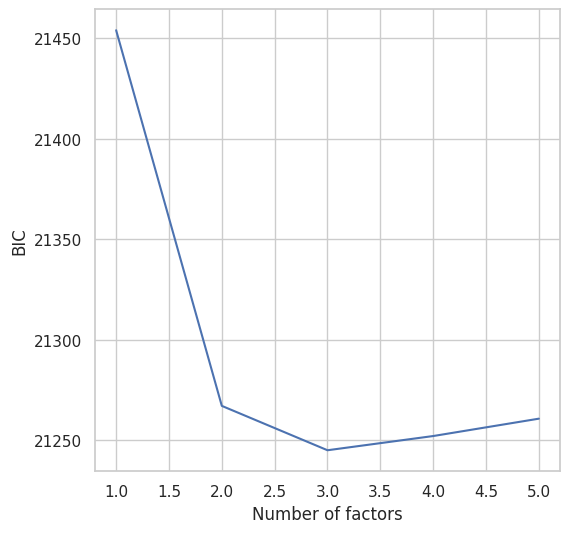

In [11]:
# transform the data into a DataFrame to allow it to be plotted easier
newdata = pd.DataFrame(data = best_subs, columns = ('factors', 'rsq', 'bic', 'aic', 'rsq_adj'))
newdata['size'] = newdata['factors'].apply(len)

plt.figure(figsize = (6, 6))
sns.lineplot(data=newdata, x='size', y='bic')
plt.xlabel('Number of factors')
plt.ylabel('BIC')

So our best subset is the one with three factors - with the three factors of "percent_lunch", "percent_college", and "rate_unemployment". If we fit the model in that way, we get this:

In [12]:
x = smf.ols(formula = 'average_act ~ percent_lunch + percent_college + rate_unemployment', data = train_data).fit()
x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            average_act   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     3328.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        23:57:38   Log-Likelihood:                -10605.
No. Observations:                5781   AIC:                         2.122e+04
Df Residuals:                    5777   BIC:                         2.125e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6258      0.114    198.064      0.000      22.402      22.850
percent_lunch        -7.5810      0.103    -73.536      0.000      -7.783      -7.379
percent_college       1.7285      0.141     12.226      0.000       1.451       2.006
rate_unemployment    -2.2944      0.413     -5.551      0.000      -3.105      -1.484
==============================================================================
Omnibus:                      493.617   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1562.725
Skew:                           0.430   Prob(JB):                         0.00
Kurtosis:                       5.397   Cond. No.                         25.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These three factors are the most important in determining the average ACT scores, in general.

That being said, we could probably examine how important each factor is in comparison with one another. To do that, we can scale them to one another.

In [13]:
test_data.agg(['max', 'min'])

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment,school_level,school_type,state,year,zip_code,average_act,region
max,196027.0,1.000000,0.998729,1.0,0.428141,High,Regular School,WY,2016-2017,99357,32.362637,SE
min,11268.0,0.093122,0.000000,0.0,0.000000,High,Alternative School,DE,2016-2017,1028,12.500000,LK


We can see that while the minimums are pretty close to zero, rate_unemployment randomly has around half of the amount of the other two factors. So, we can add another value to the dataset scaling the factors to each other, on a scale from 0-1.

In [32]:
max_train = test_data.agg('max')
max_college = max_train['percent_college']
max_lunch = max_train['percent_lunch']
max_unemployment = max_train['rate_unemployment']
min_train = test_data.agg('min')
min_college = min_train['percent_college']
min_lunch = min_train['percent_lunch']
min_unemployment = min_train['rate_unemployment']
train_data['scaled_college'] = (train_data['percent_college']-min_college)/(max_college-min_college)
train_data['scaled_lunch'] = (train_data['percent_lunch']-min_lunch)/(max_lunch-min_lunch)
train_data['scaled_unemploy'] = (train_data['rate_unemployment']-min_unemployment)/(max_unemployment-min_unemployment)

train_data

,median_income,percent_college,percent_lunch,percent_married,rate_unemployment,school_level,school_type,state,year,zip_code,average_act,region,scaled_college,scaled_lunch,scaled_unemploy
0,47045.0,0.709632,0.996328,0.050633,0.157769,High,Regular School,PA,2016-2017,19130,18.028083,NE,0.679816,0.997596,0.368499
1,35410.0,0.499124,0.431373,0.529361,0.124807,High,Regular School,MI,2016-2017,49677,18.400000,LK,0.447692,0.431922,0.291510
2,79491.0,0.595070,0.138767,0.843700,0.078671,High,Regular School,NJ,2016-2017,7405,21.178266,NE,0.553491,0.138943,0.183749
3,31935.0,0.440022,0.517966,0.548566,0.081267,High,Regular School,TX,2016-2017,79924,17.979243,S,0.382521,0.518625,0.189814
4,102346.0,0.879287,0.380036,0.943607,0.034535,High,Regular School,NC,2016-2017,28078,19.786325,SE,0.866891,0.380520,0.080664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5776,67188.0,0.522486,0.289902,0.819840,0.080593,High,Regular School,TX,2016-2017,76064,20.177045,S,0.473453,0.290271,0.188239
5777,92188.0,0.835048,0.148490,0.782456,0.078107,High,Regular School,MI,2016-2017,48360,22.500000,LK,0.818110,0.148679,0.182432
5778,36694.0,0.427376,0.321260,0.658777,0.104116,High,Regular School,MI,2016-2017,48444,19.600000,LK,0.368577,0.321669,0.243182
5779,65611.0,0.667860,0.297581,0.770891,0.043150,High,Regular School,TX,2016-2017,76131,20.470085,S,0.633754,0.297960,0.100785


Then, using the scaled dataset, we get this:

In [33]:
x = smf.ols(formula = 'average_act ~ scaled_lunch + scaled_college + scaled_unemploy', data = train_data).fit()
x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            average_act   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     3328.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        23:58:40   Log-Likelihood:                -10605.
No. Observations:                5781   AIC:                         2.122e+04
Df Residuals:                    5777   BIC:                         2.125e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          22.7867      0.102    222.880      0.000      22.586      22.987
scaled_lunch       -7.5714      0.103    -73.536      0.000      -7.773      -7.370
scaled_college      1.5676      0.128     12.226      0.000       1.316       1.819
scaled_unemploy    -0.9823      0.177     -5.551      0.000      -1.329      -0.635
==============================================================================
Omnibus:                      493.617   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1562.725
Skew:                           0.430   Prob(JB):                         0.00
Kurtosis:                       5.397   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on this, we can see that, based on the scaling, percent_lunch has the most important say in determining the average ACT scores. We can visualize it:

Text(0, 0.5, '')

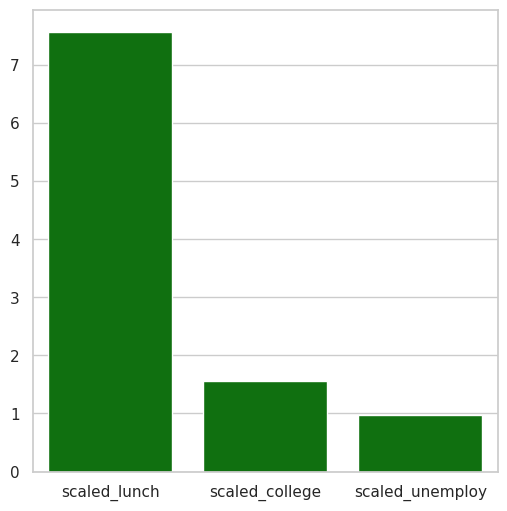

In [43]:
paramplot = pd.DataFrame(data = [abs(x.params)])

plt.figure(figsize = (6, 6))
sns.barplot(data = paramplot.loc[:,'scaled_lunch':'scaled_unemploy'], color = 'green', ax = None)
plt.ylabel(None)


So we have a general model. Using the test data we determined earlier, we can calculate the overall test error (using mean square error for each individual point):

In [17]:
x = smf.ols(formula = 'average_act ~ percent_lunch + percent_college + rate_unemployment', data = train_data).fit()

test_error = ((x.predict(test_data)-test_data['average_act'])**2).mean()
test_error

2.521312733050168

So we have the "best" model based on the numerical regression.

Now, we can ask the question: does adding state and/or region in as a factor improve the model at all? Does that affect any aspect of what we have here?

In [18]:
x = smf.ols(formula = 'average_act ~ percent_lunch + percent_college + rate_unemployment + C(region)',
            data = train_data).fit()
x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            average_act   R-squared:                       0.642
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     1295.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        23:57:38   Log-Likelihood:                -10535.
No. Observations:                5781   AIC:                         2.109e+04
Df Residuals:                    5772   BIC:                         2.115e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.6418      0.115    196.886      0.000      22.416      22.867
C(region)[T.N]       -2.1410      0.263     -8.134      0.000      -2.657      -1.625
C(region)[T.NE]      -0.1139      0.054     -2.112      0.035      -0.220      -0.008
C(region)[T.NW]       0.7172      0.108      6.632      0.000       0.505       0.929
C(region)[T.S]        0.1811      0.061      2.994      0.003       0.063       0.300
C(region)[T.SE]       0.1642      0.055      3.013      0.003       0.057       0.271
percent_lunch        -7.6826      0.103    -74.370      0.000      -7.885      -7.480
percent_college       1.6931      0.142     11.961      0.000       1.416       1.971
rate_unemployment    -2.3511      0.416     -5.650      0.000      -3.167      -1.535
==============================================================================
Omnibus:                      563.471   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1851.560
Skew:                           0.487   Prob(JB):                         0.00
Kurtosis:                       5.596   Cond. No.                         27.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Compared to the R-squared of the "best" subset, adding "region" appears to only add around a 0.008 bonus - we go from about 0.62 to 0.628. This suggests that regional differences don't have that big of an impact compared to the other factors.

If we focus specifically on its relationship with the most important variable, percent_lunch:

In [19]:
x = smf.ols(formula = 'average_act ~ percent_lunch * C(region)',
            data = train_data).fit()
x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            average_act   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     901.5
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        23:57:38   Log-Likelihood:                -10615.
No. Observations:                5781   AIC:                         2.125e+04
Df Residuals:                    5769   BIC:                         2.133e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        23.4163      0.063    371.627      0.000      23.293      23.540
C(region)[T.N]                   -1.4076      0.593     -2.375      0.018      -2.570      -0.246
C(region)[T.NE]                   0.5772      0.098      5.873      0.000       0.385       0.770
C(region)[T.NW]                   1.5358      0.243      6.313      0.000       1.059       2.013
C(region)[T.S]                    0.3289      0.133      2.474      0.013       0.068       0.590
C(region)[T.SE]                   0.5506      0.128      4.287      0.000       0.299       0.802
percent_lunch                    -7.7557      0.145    -53.606      0.000      -8.039      -7.472
percent_lunch:C(region)[T.N]     -3.0018      2.833     -1.060      0.289      -8.555       2.552
percent_lunch:C(region)[T.NE]    -1.6060      0.212     -7.575      0.000      -2.022      -1.190
percent_lunch:C(region)[T.NW]    -1.8846      0.589     -3.200      0.001      -3.039      -0.730
percent_lunch:C(region)[T.S]     -0.3926      0.271     -1.449      0.147      -0.924       0.138
percent_lunch:C(region)[T.SE]    -0.9498      0.263     -3.608      0.000      -1.466      -0.434
==============================================================================
Omnibus:                      533.292   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1603.799
Skew:                           0.486   Prob(JB):                         0.00
Kurtosis:                       5.391   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

...we can see that with these two variables specifically, there's potentially a pretty significant shift by factoring in the region into the model.

If we plot the different lines as a result of this, we get:

Text(0.5, 36.26562499999997, 'Percentage of Students on Free/Reduced Lunch')

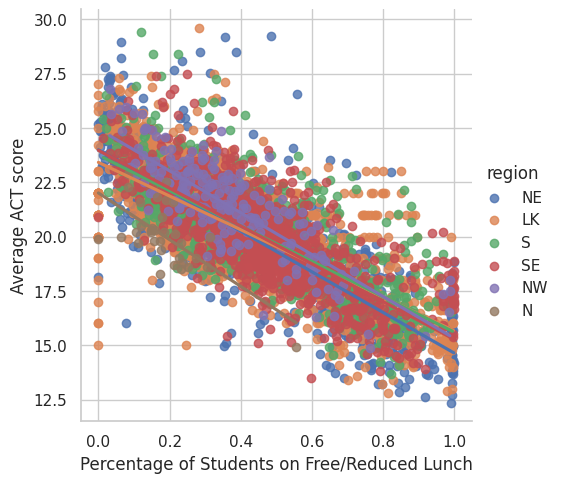

In [44]:
sns.lmplot(data=train_data, x = 'percent_lunch', y = 'average_act', hue = 'region', ci=None)
plt.ylabel('Average ACT score')
plt.xlabel('Percentage of Students on Free/Reduced Lunch')

There's notably relatively divergent lines when comparing the regression lines across different regions. At the same time, the lines are still pretty close to each other, so maybe it's not very reliable to compare across regions.

For context, this is the base regression with just the percent_lunch:

In [21]:
base = smf.ols(formula = 'average_act ~ percent_lunch',
            data = train_data).fit()
base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            average_act   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     9383.
Date:                Thu, 04 May 2023   Prob (F-statistic):               0.00
Time:                        23:57:40   Log-Likelihood:                -10718.
No. Observations:                5781   AIC:                         2.144e+04
Df Residuals:                    5779   BIC:                         2.145e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        23.7398      0.041    579.164      0.000      23.659      23.820
percent_lunch    -8.4175      0.087    -96.864      0.000      -8.588      -8.247
==============================================================================
Omnibus:                      469.180   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1389.839
Skew:                           0.427   Prob(JB):                    1.59e-302
Kurtosis:                       5.245   Cond. No.                         5.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

One more thing we can look at: whether the regression can shift based on subselecting parts of the dataset based on their region.

In [22]:
arealist = ['N', 'NE', 'NW', 'S', 'SE', 'LK']

intercept_slope_list = []
rsquared_list = []

for b in arealist:
  y = smf.ols(formula = 'average_act ~ percent_lunch',
            data = train_data[train_data['region'] == b]).fit()
  intercept_slope_list.append(y.params)
  rsquared_list.append((b, y.rsquared))

intercept_slope_list

[Intercept        22.008710
 percent_lunch   -10.757465
 dtype: float64,
 Intercept        23.993547
 percent_lunch    -9.361736
 dtype: float64,
 Intercept        24.952070
 percent_lunch    -9.640314
 dtype: float64,
 Intercept        23.745253
 percent_lunch    -8.148261
 dtype: float64,
 Intercept        23.966925
 percent_lunch    -8.705501
 dtype: float64,
 Intercept        23.416313
 percent_lunch    -7.755707
 dtype: float64]

If we plot these, we get this:

Text(0.5, 0, 'Intercept')

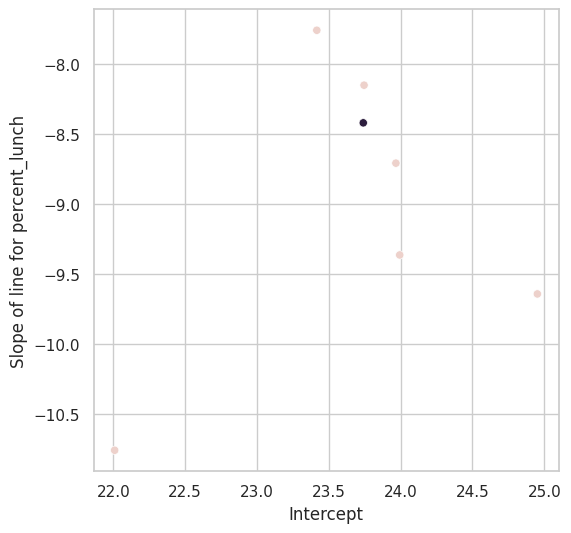

In [45]:
intercept_df = pd.DataFrame(intercept_slope_list)
intercept_df['source'] = 1
attach = base.params
intercept_df.loc[6, 'Intercept'] = attach['Intercept']
intercept_df.loc[6, 'percent_lunch'] = attach['percent_lunch']
intercept_df.loc[6, 'source'] = 2


plt.figure(figsize = (6, 6))
sns.scatterplot(data=intercept_df, x = 'Intercept', y = 'percent_lunch', hue='source', legend = None)
plt.ylabel('Slope of line for percent_lunch')
plt.xlabel('Intercept')

There does seem to be a difference here. It's somewhat slight, but the lines are significantly different based on the region.

The r-squared values are somewhat shifty, though, based on the region given.

In [24]:
rsquared_list

[('N', 0.4537598333505751),
 ('NE', 0.7321296931990222),
 ('NW', 0.6824849584623786),
 ('S', 0.6041872161275167),
 ('SE', 0.6010024825968591),
 ('LK', 0.543414405537879)]

Considering the r-squared of the standard model is about 0.61, some have much higher and some have much lower r-squared values. This means that it's probably not as reliable with certain regions compared to taking it all as a whole. It looks like we can't really rely on these regions to predict ACT scores, especially any in the "N" region. There are some regions where the r-squared value is pretty good, though, so it might be relevant if it's part of that subset.

If we look at how well it actually predicts the testing data, we have more of an issue.

Compared to the mean squared error of just percent_lunch by itself, predicting average ACT scores, you have:

In [25]:
x = smf.ols(formula = 'average_act ~ percent_lunch',
            data = train_data).fit()
((x.predict(test_data)-test_data['average_act'])**2).mean()

2.5950539693173624

In contrast, the average MSE for predicting the average ACT scores for each region is:

In [46]:
accuracy = []

for b in arealist:
  y = smf.ols(formula = 'average_act ~ percent_lunch',
            data = train_data[train_data['region'] == b]).fit()
  test_error = ((y.predict(test_data[test_data['region'] == b])-test_data[test_data['region'] == b]['average_act'])**2).mean()
  accuracy.append((b, test_error))
accuracy

[('N', 1.0609406447611813),
 ('NE', 3.543900378357964),
 ('NW', 1.8064473024889018),
 ('S', 2.108328474845341),
 ('SE', 2.5907130703820074),
 ('LK', 2.28362812478496)]

Considering the test data MSE of just percent_lunch by itself, it's a little hit or miss in terms of accuracy in prediction as well. One region has significantly more MSE than the average, while a few regions have significantly less.

The total MSE in adding the region to the factors is:

In [47]:
x = smf.ols(formula = 'average_act ~ percent_lunch * C(region)',
            data = train_data).fit()
((x.predict(test_data)-test_data['average_act'])**2).mean()

2.53618852115032

It's only about a 0.06 improvement overall - it's not really worth it. The other two factors decrease that MSE by more than region individually.

## Conclusion

In general, we can determine:
- Percentage of students on free/reduced lunch is a key factor in determining ACT scores, while percentage of college graduates and unemployment rate are both relevant enough to help determine ACT scores.
- The region a school is in can help a little bit with determining the average ACT scores, but doesn't seem as reliable as the other factors.